## Predictive Modeling: Cancer Mortality Forecasting

In [32]:
!pip install prophet

## 1. Preprocessing

**Goal:**

- Clean and align mortality data (2003–2015) by PHU

- Integrate SDOH (2016 or 2021 snapshot)

- Prepare structured dataset for both time-series and supervised regression forecasting

**Step 1: Import libralies**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


**Step 2: Load all datasets**

In [34]:


import pandas as pd
import numpy as np

# Load dataframe CSVs 
mort = pd.read_csv("Cancer_Mortality_Snapshot_2003_2015.csv") # Cancer Mortality
sdoh = pd.read_csv("SDOH_Clean_Wide.csv") 

# Inspect structure

print("Mortality data\n", mort.head())
print("SDOH data\n", sdoh.head())

Mortality data
                     Indicator                             Measure  Year  \
0  Mortality from all cancers  Age-standardized rate (both sexes)  2003   
1  Mortality from all cancers  Age-standardized rate (both sexes)  2004   
2  Mortality from all cancers  Age-standardized rate (both sexes)  2005   
3  Mortality from all cancers  Age-standardized rate (both sexes)  2006   
4  Mortality from all cancers  Age-standardized rate (both sexes)  2007   

              Geography   Rate 95% Confidence Interval  Count  Population  \
0  Algoma Public Health  254.5           (226.5-282.6)    330      120708   
1  Algoma Public Health  258.5           (231.1-285.9)    353      120353   
2  Algoma Public Health  262.0           (234.7-289.2)    367      120282   
3  Algoma Public Health  251.5           (225.0-278.0)    355      119936   
4  Algoma Public Health  225.4           (200.7-250.1)    328      119808   

  Significance Compared to Ontario  
0                               N

**Step 3: Data Filter and Cleaning**

From the mortality data set, we select the Age-standardized for both sexes and all cancers for simplicity. We are not treating sexes or cancer types separately. 

In [35]:
# Select the dataset of interest and some columns
mort_filtered = mort[(mort['Indicator'] == 'Mortality from all cancers') &
                     (mort['Measure'] == 'Age-standardized rate (both sexes)')].drop(columns= ['Indicator', 'Measure'] )

In [36]:

#Standardize column names
#Make sure variable names are consistent across datasets.
mort_filtered.rename(columns={
    "Geography": "PHU",
    "95% Confidence Interval": "95% CI MortalityRate",
    "Rate": "MortalityRate"
}, inplace=True)

sdoh.rename(columns={
    "Geography": "PHU",
    'Per cent (%) immigrant population':'Immigrant rate', 
    'Per cent (%) lone parent households': 'Lone parent households rate', 
    'Per cent (%) of households spending more than 30% of their income on shelter costs' : 'Households spending more than 30%', 
    'Per cent (%) of the labour force population who are unemployed': 'Unemployed labour force rate', 
    'Per cent (%) of the population in the labour force (participation rate)': 'Participating labour force rate ', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 0 to 17': '(LICO-AT) - Ages 0 to 17', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 18 to 64': '(LICO-AT) - Ages 18 to 64', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 65+':'(LICO-AT) - Ages 65+' , 
    'Per cent (%) of the population living in low income (LICO-AT) - All ages': '(LICO-AT) - All ages', 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 0 to 17': '(LIM-AT) - Ages 0 to 17', 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 18 to 64':'(LIM-AT) - Ages 18 to 64' , 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 65+' :' (LIM-AT) - Ages 65+', 
    'Per cent (%) of the population living in low income (LIM-AT) - All ages': '(LIM-AT) - All ages', 
    'Per cent (%) of the population who are employed':'Rate of employment',
    'Per cent (%) of the population who cannot speak English or French': 'Rate of no English or French speakers', 
    'Per cent (%) of the population with a high school diploma or post-secondary degree/diploma/certificate':'Rate of high school or post-secondary graduate', 
    'Per cent (%) of the population with a post-secondary degree/diploma/certificate': 'Rate of post-secondary graduate', 
    'Per cent (%) of the population without a high school diploma': 'Rate of no high school diploma holders', 
    'Per cent (%) recent immigrant population': 'Rate of recent immigrant', 
    'Per cent (%) senior population': 'Rate of Senior',
    'Per cent (%) visible minority population': ' Rate of visible minority'
 
}, inplace=True)

The SDOH dataset has only 2016 and 2021. We pick 2016 because it’s immediately after the cancer mortality window (2003–2015), because using 2021 would be “future” socioeconomic data relative to the cancer outcomes.

In [37]:
#Filter the 2016 SDOH dataset
sdoh_2016 = sdoh[sdoh["Year"] == 2016]  # snapshot as lagged socioeconomic proxy

**Step 4: Check for missing values and duplicates**

In [38]:

print("Missing values:")
print(mort_filtered.isna().sum())
print(sdoh_2016.isna().sum())

print("Duplicates:")
print(mort_filtered.duplicated().sum(), sdoh.duplicated().sum())

Missing values:
Year                                 0
PHU                                  0
MortalityRate                        0
95% CI MortalityRate                 0
Count                                0
Population                           0
Significance Compared to Ontario    78
dtype: int64
PHU                                               0
Year                                              0
Immigrant rate                                    0
Lone parent households rate                       0
Households spending more than 30%                 0
Unemployed labour force rate                      0
Participating labour force rate                   0
(LICO-AT) - Ages 0 to 17                          0
(LICO-AT) - Ages 18 to 64                         0
(LICO-AT) - Ages 65+                              0
(LICO-AT) - All ages                              0
(LIM-AT) - Ages 0 to 17                           0
(LIM-AT) - Ages 18 to 64                          0
 (LIM-AT) - Ages 65+  

## 2. Exploratory Data Analysis (EDA)

**Mortality Trends Over Time**

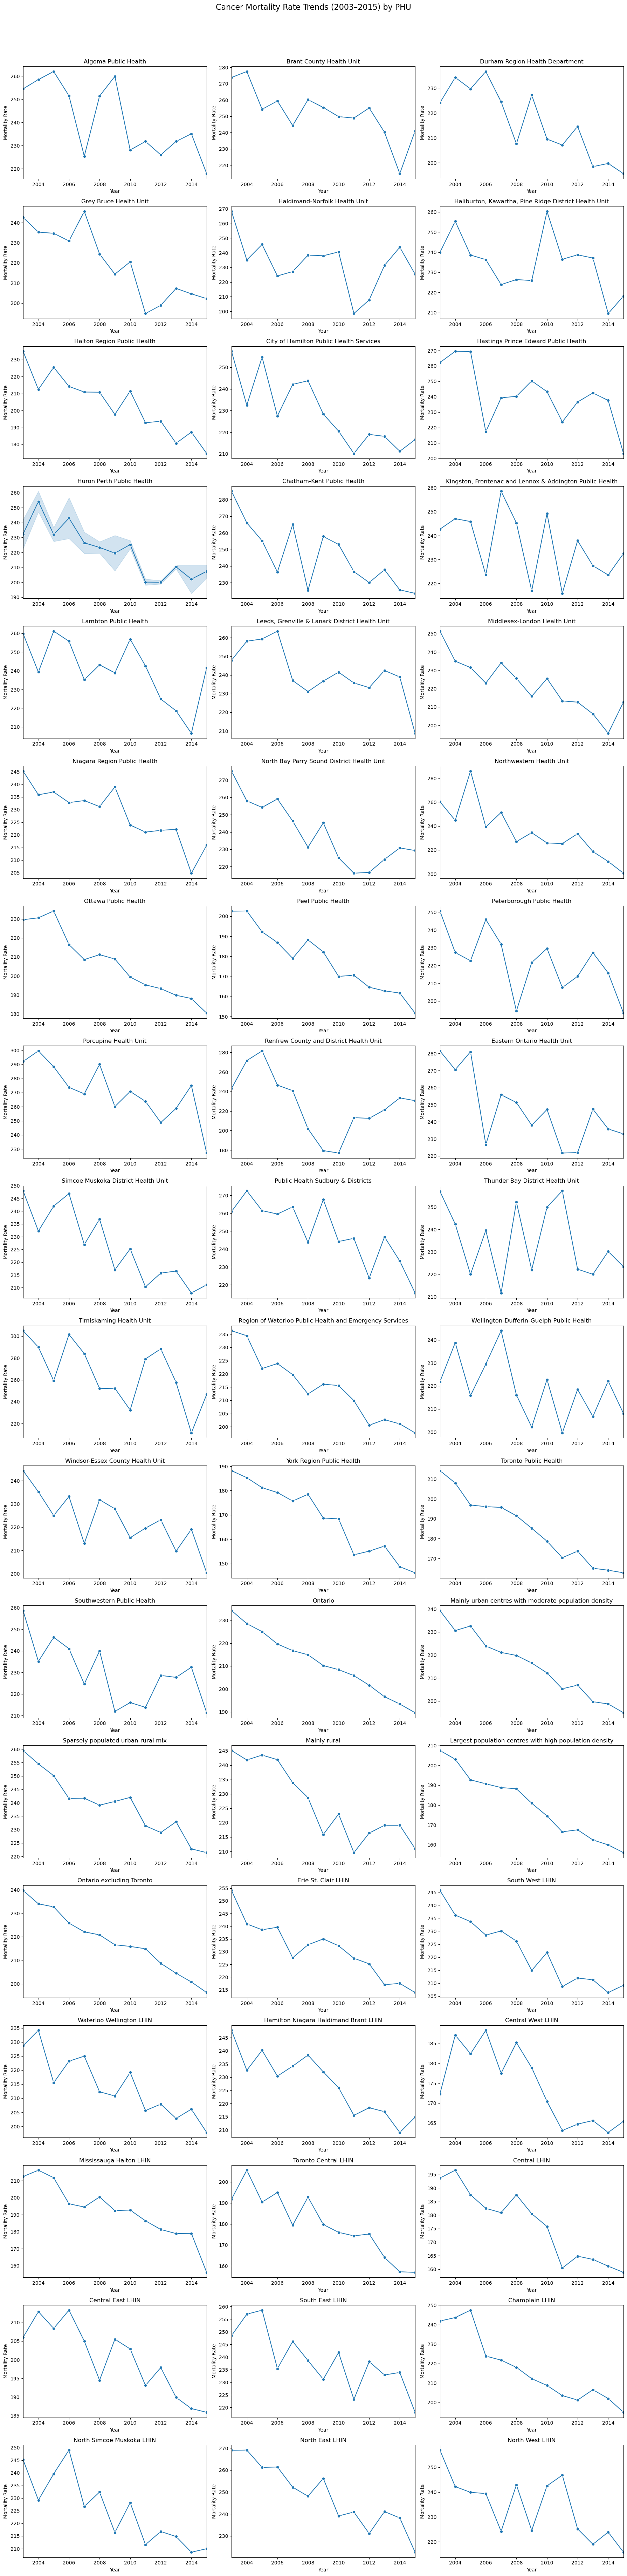

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates

# List of PHUs
phus = mort_filtered["PHU"].unique()
n_phus = len(phus)

# Define subplot grid
cols = 3  # number of columns per row
rows = math.ceil(n_phus / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

# Plot each PHU separately
for i, phu in enumerate(phus):
    ax = axes[i]
    phu_data = mort_filtered[mort_filtered["PHU"] == phu]
    sns.lineplot(data=phu_data, x="Year", y="MortalityRate", marker="o", ax=ax)
    ax.set_title(phu)
    ax.set_xlabel("Year")
    ax.set_ylabel("Mortality Rate")
    ax.set_xlim(2003, 2015)  # for numeric years

    
    

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.suptitle("Cancer Mortality Rate Trends (2003–2015) by PHU", fontsize=16, y=1.02)
plt.show()

plt.savefig("Cancer Mortality Rate Age_stdized rate(2003–2015) by Geography", dpi=300, bbox_inches="tight")


**Correlation of 2016 SDOH with Average Mortality**

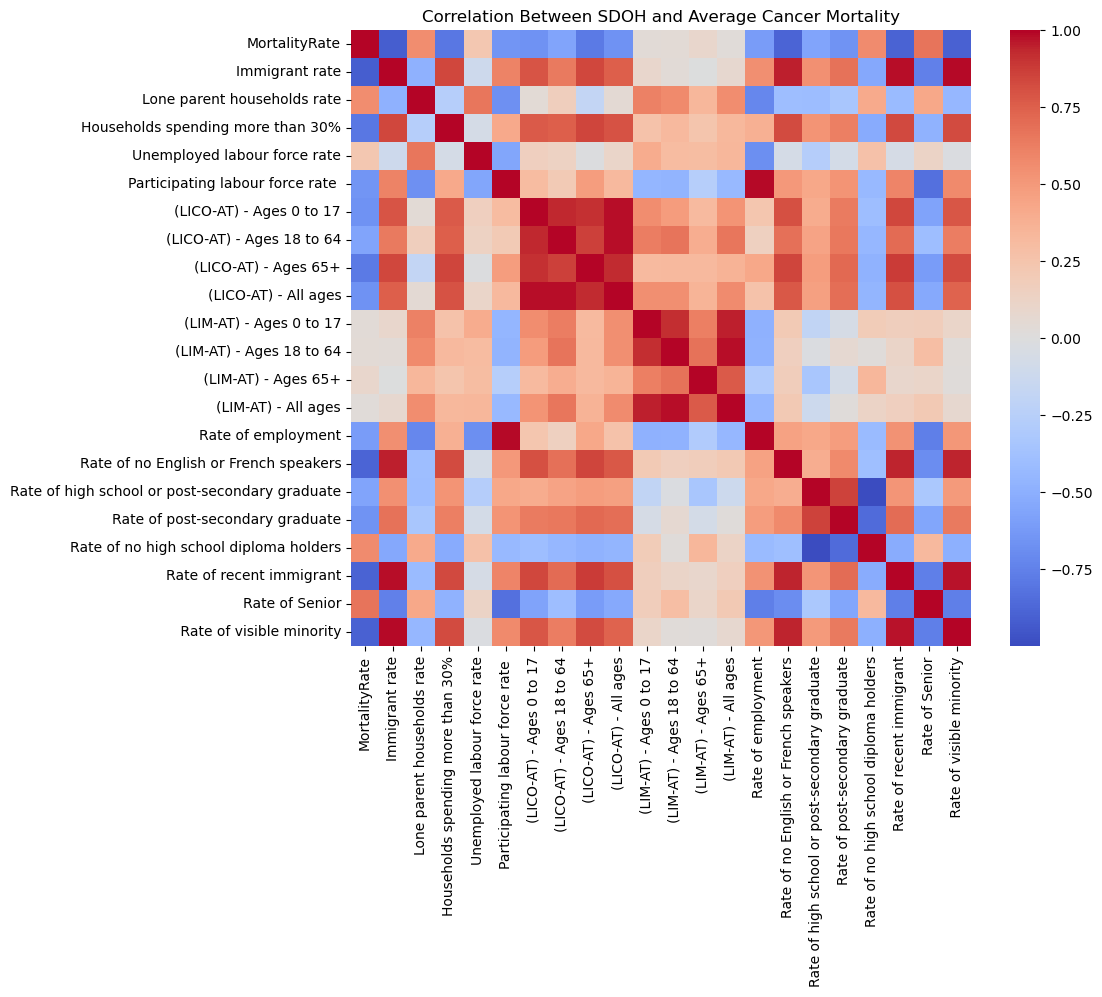

Plot saved as: Mortality_SDOH2016 Correlation


<Figure size 640x480 with 0 Axes>

In [40]:
mort_mean = mort_filtered.groupby("PHU", as_index=False)["MortalityRate"].mean()
merged_mean = mort_mean.merge(sdoh_2016.drop(columns=['Year']), on="PHU", how="left")
corr = merged_mean.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between SDOH and Average Cancer Mortality")
plt.show()

plt.savefig('Mortality_SDOH2016 Correlation', dpi=300, bbox_inches="tight")
print(f"Plot saved as: {'Mortality_SDOH2016 Correlation'}")

# 3. Model 1: Time-Series Forecasting (Prophet)

**Goal:**

Predict future (2016–2026) mortality rates for each PHU individually

**Fit Prophet Model and Visualize Forecast**

18:25:00 - cmdstanpy - INFO - Chain [1] start processing
18:25:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:00 - cmdstanpy - INFO - Chain [1] start processing
18:25:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:01 - cmdstanpy - INFO - Chain [1] start processing
18:25:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date

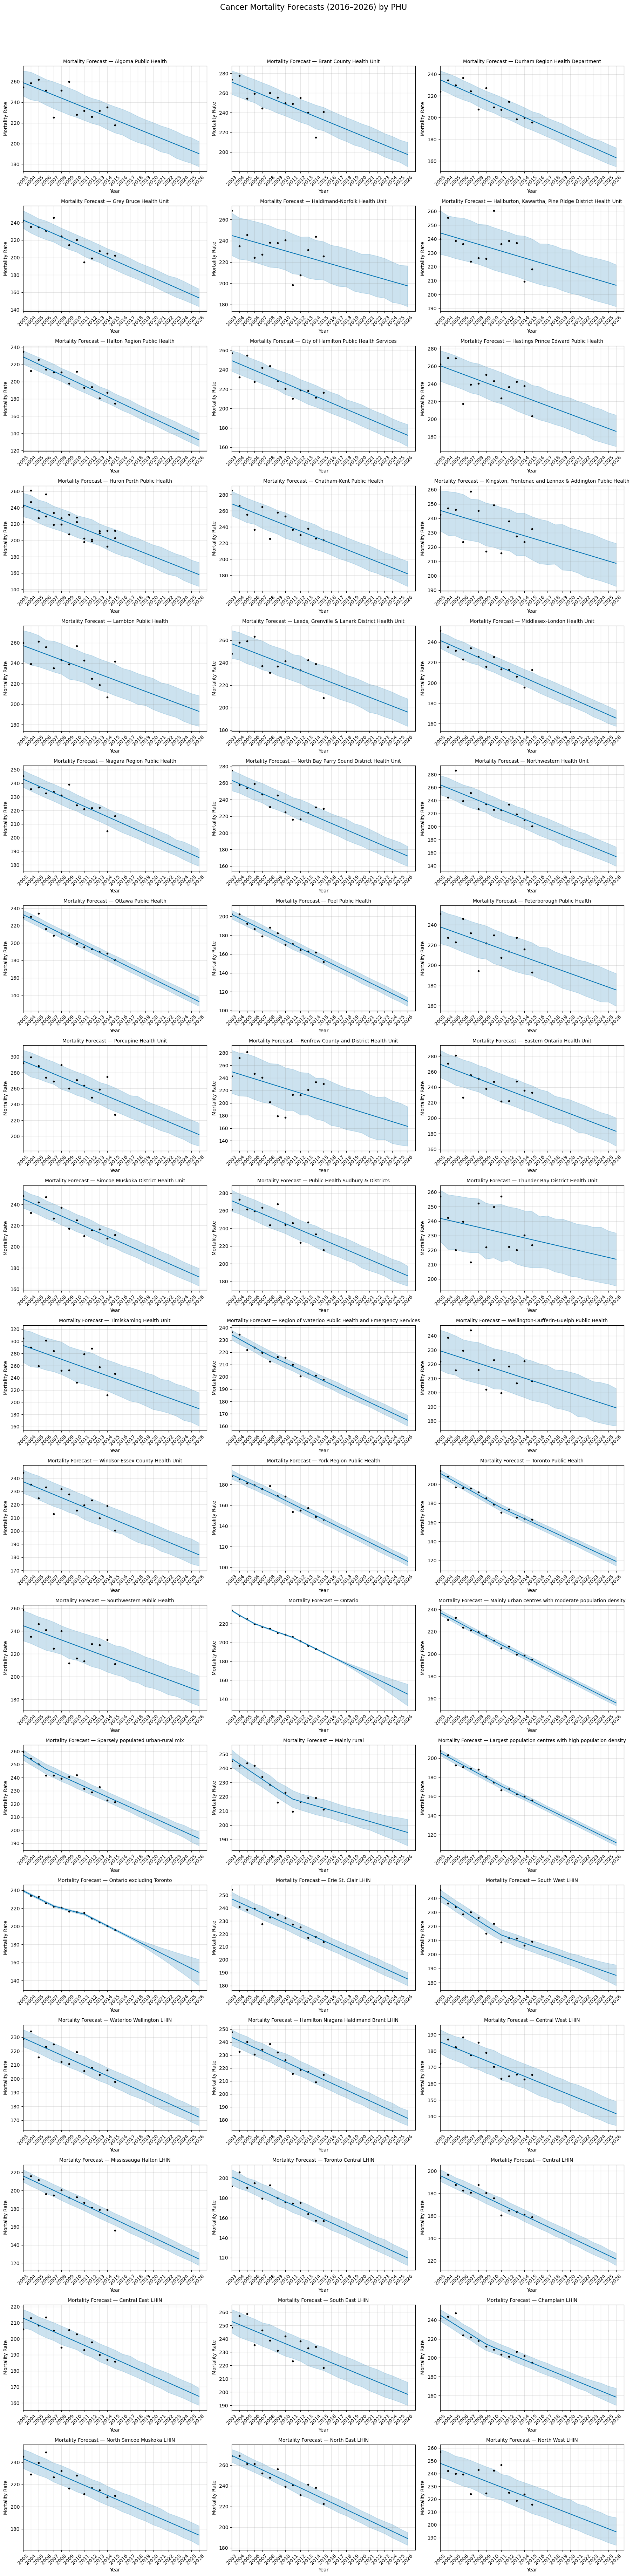

<Figure size 640x480 with 0 Axes>

In [41]:
import math
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib.dates as mdates

# List of all PHUs
phus = mort_filtered["PHU"].unique()

# Prepare subplots
cols = 3   # number of columns
rows = math.ceil(len(phus) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

start_year = 2003
end_year = 2026


forecast_list = []
# Loop through PHUs and create Prophet forecasts
for i, phu in enumerate(phus):
    # Prepare data for Prophet
    df_phu = mort_filtered[mort_filtered["PHU"] == phu][["Year", "MortalityRate"]].copy()
    df_phu = df_phu.rename(columns={"Year": "ds", "MortalityRate": "y"})
    df_phu["ds"] = pd.to_datetime(df_phu["ds"].astype(str) + "-01-01") #convert Year to datatime format(Jan 1st of each year)

    # Fit Prophet model
    model = Prophet(yearly_seasonality=False)
    model.fit(df_phu)

    # Create future dataframe (forecast horizon, e.g., 10 years ahead) 2016-2026
    future = model.make_future_dataframe(periods=11, freq='Y')
    forecast = model.predict(future)

    forecast["PHU"] = phu
    forecast_list.append(forecast[["ds", "yhat", "PHU"]])

    # Plot forecast in subplot (for each PHU)
    model.plot(forecast, ax=axes[i])
    axes[i].set_title(f"Mortality Forecast — {phu}", fontsize=10)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Mortality Rate")
    
    # Set x-axis range and ticks
    axes[i].set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))
    axes[i].xaxis.set_major_locator(mdates.YearLocator(1)) #tick every year
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) #show year only
    axes[i].tick_params(axis='x', rotation=45) #rotate year labels for clarity

forecast_all = pd.concat(forecast_list)
forecast_all["Year"] = forecast_all["ds"].dt.year

# Turn off extra axes if grid > PHU count
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.suptitle("Cancer Mortality Forecasts (2016–2026) by PHU", fontsize=16, y=1.02)
plt.show()
plt.savefig("Forecasted_Cancer Mortality Rate Age_stdized rate(2003–2026) by Geography", dpi=300, bbox_inches="tight")


# 4. Model 2: Supervised Regression (Random Forest)

**Predict mortality rate(future years) using historical mortality and 2016 SDOH features**

In [42]:
# Feature Engineering
#Aggregate mortality by average per PHU
mort_agg = mort_filtered.groupby("PHU").agg({
    "MortalityRate": ["mean"] # cand do "MortalityRate": ["mean", "std", "min", "max"]
})
mort_agg.columns = ["Mortality_Mean"] # Can do mort_agg.columns = ["Mortality_Mean", "Mortality_SD", "Mortality_Min", "Mortality_Max"]
mort_agg = mort_agg.reset_index()


# Merge with SDOH data Excluding year column 

model_data = mort_agg.merge(sdoh_2016.drop(columns=["Year"]), on="PHU", how="left")


In [43]:
#Split Data
X = model_data.drop(columns=["PHU", "Mortality_Mean"])
y = model_data["Mortality_Mean"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Pipeline Definition
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

In [45]:
# Hyperparameter Tuning with GridSearchCV
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [5, 10, 20, None],

}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='r2',             # Can also use 'neg_mean_squared_error'
    n_jobs=-1,                # Parallelize
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 20, None],
                         'rf__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=2)

In [46]:
# Best Model Evaluation
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated R²: {grid_search.best_score_:.3f}")

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Test Set Performance ---")
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")


Best Parameters: {'rf__max_depth': 5, 'rf__n_estimators': 200}
Best Cross-Validated R²: 0.743

--- Test Set Performance ---
R²: 0.915
MSE: 40.763


In [47]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nAverage CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")



Average CV R²: 0.786 ± 0.086


C:\Users\AlexandreT2\AppData\Local\Temp\ipykernel_27916\3166656453.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="magma")


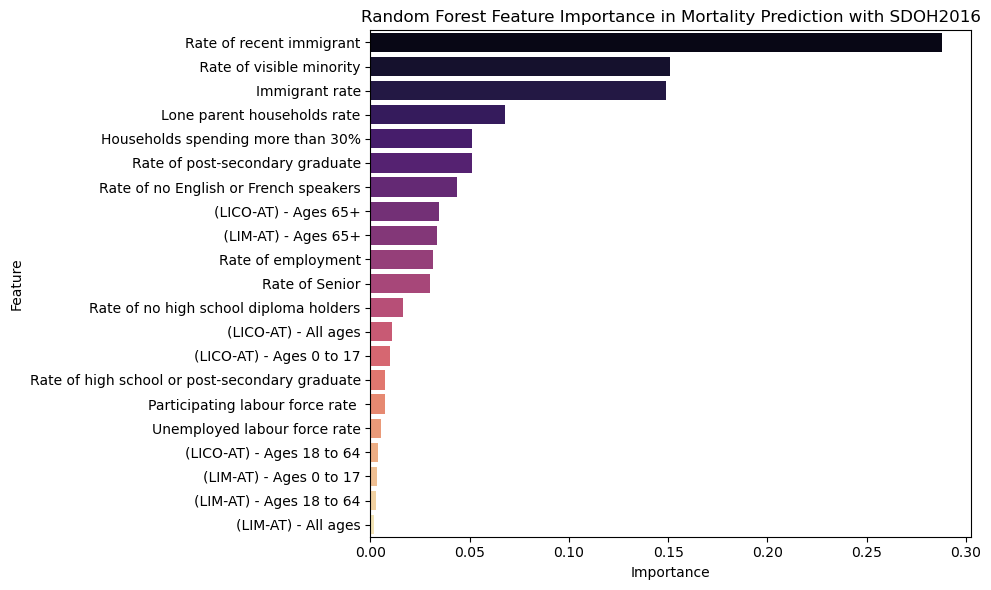

<Figure size 640x480 with 0 Axes>

In [48]:

# ======================================================
# Feature Importance for RandomForest 
# ======================================================

# Extract trained RandomForestRegressor from pipeline
rf_model = best_model.named_steps['rf']

# Create DataFrame of features and importance
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="magma")
plt.title("Random Forest Feature Importance in Mortality Prediction with SDOH2016")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.savefig("Random Forest Feature Importance in Mortality Prediction with SDOH2016", dpi=300, bbox_inches="tight")

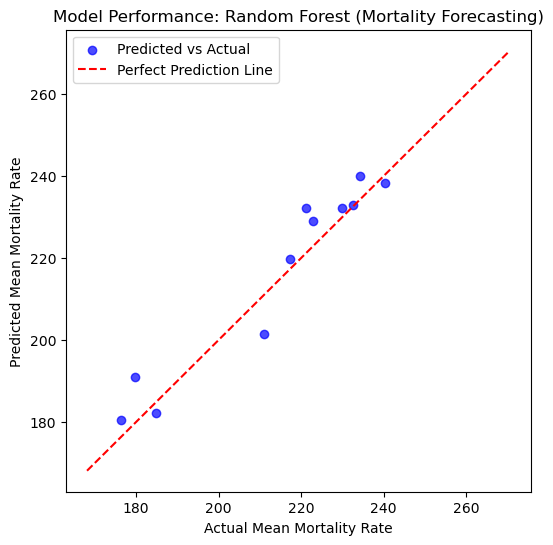

<Figure size 640x480 with 0 Axes>

In [49]:
# Visualization: Actual Vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction Line' )
plt.xlabel("Actual Mean Mortality Rate")
plt.ylabel("Predicted Mean Mortality Rate")
plt.title("Model Performance: Random Forest (Mortality Forecasting)")
plt.legend()
plt.show()

plt.savefig("Random Forest (Mortality Forecasting) with SDOH2016", dpi=300, bbox_inches="tight")

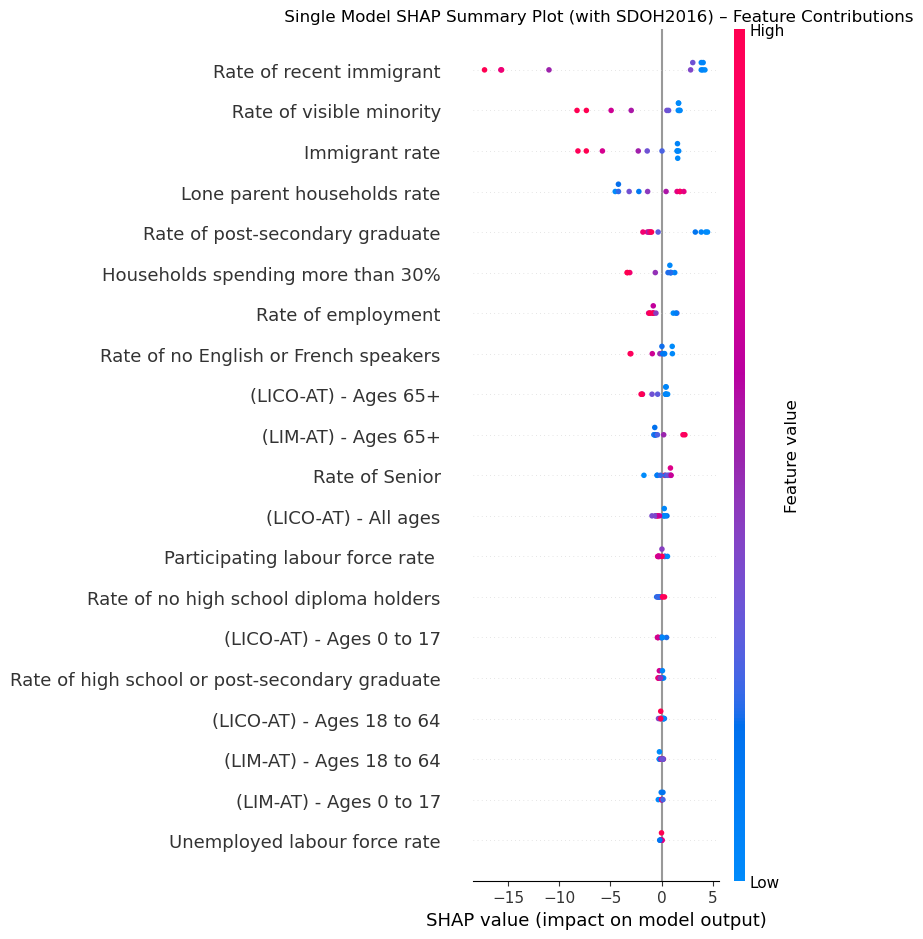

<Figure size 640x480 with 0 Axes>

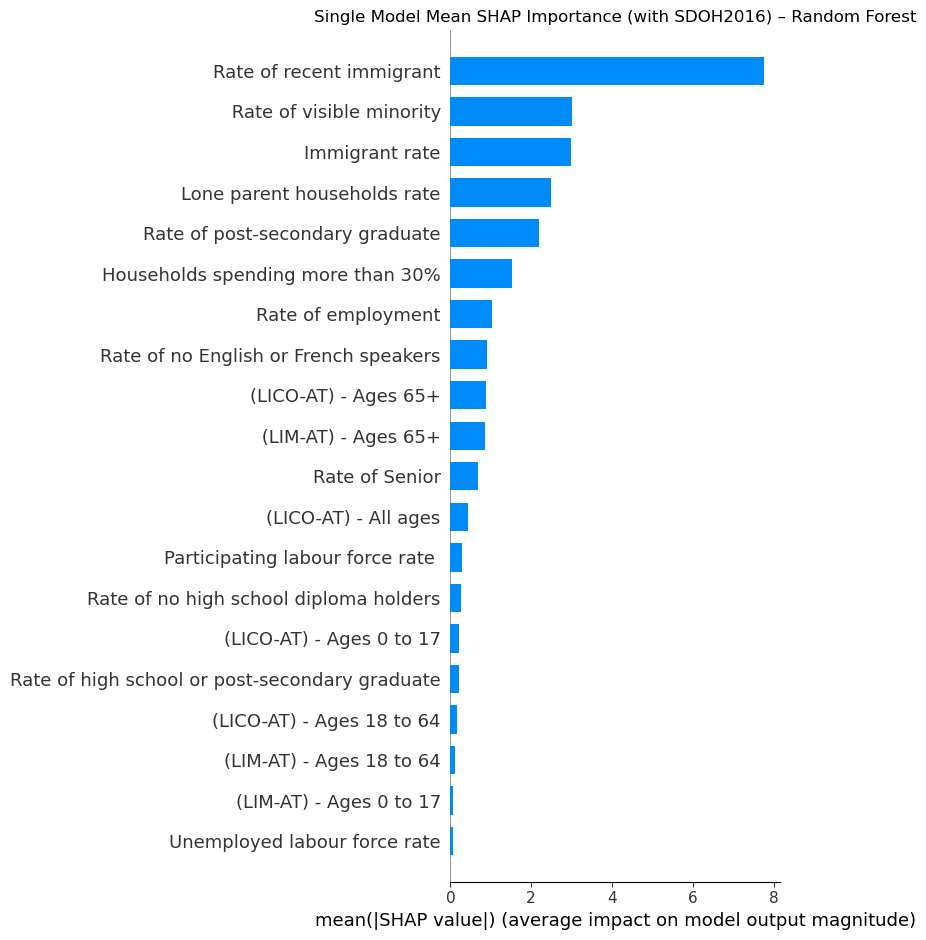

<Figure size 640x480 with 0 Axes>

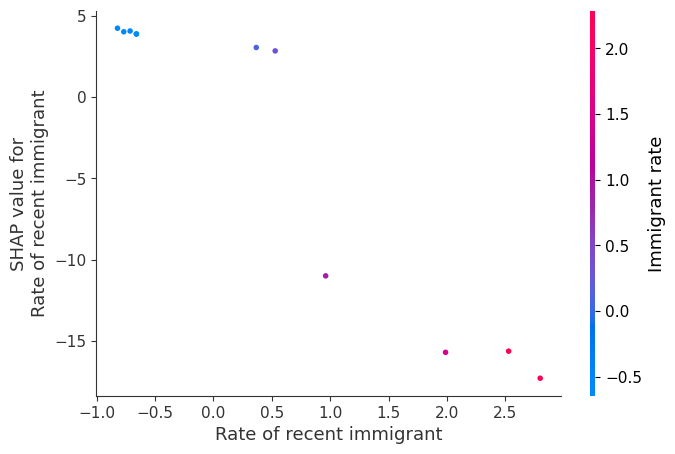

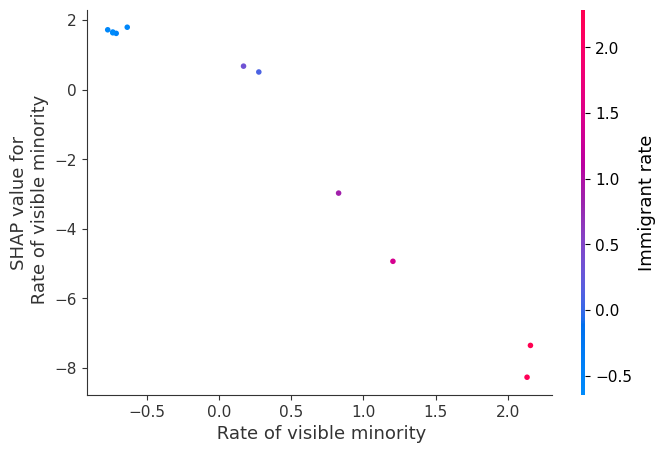

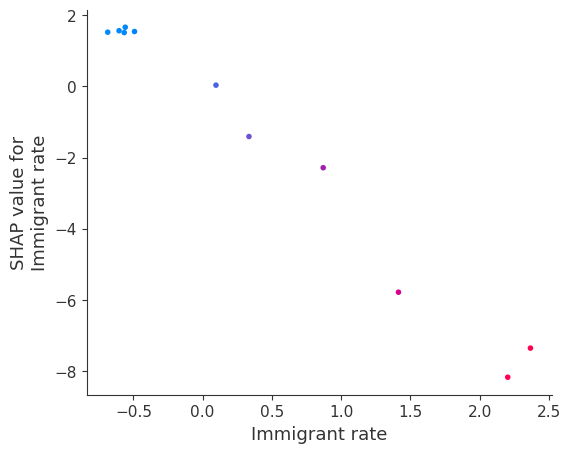

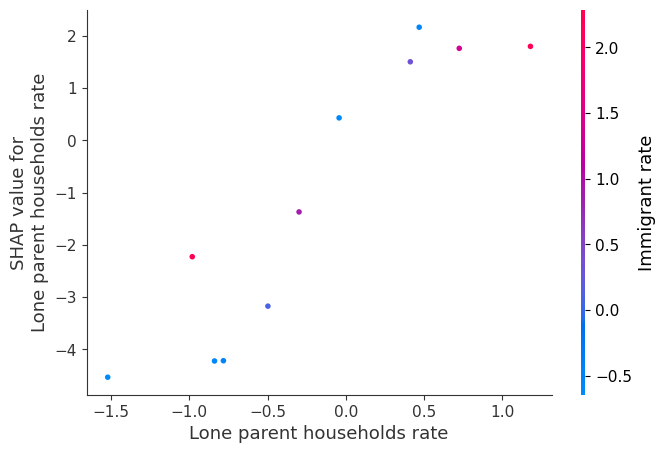

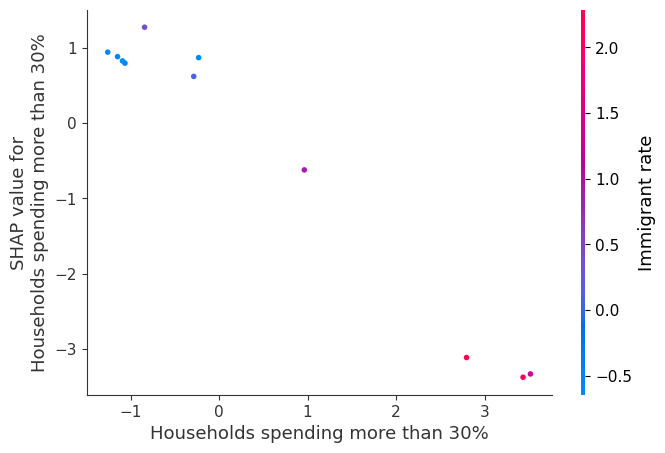

In [50]:
import shap

# Extract trained RandomForestRegressor
rf_model = best_model.named_steps['rf']
scaler = best_model.named_steps['scaler']

# Scale X_test for the RF model
X_test_scaled = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize SHAP TreeExplainer on the RandomForest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# 1. SHAP Summary Plot (Dot)
plt.figure(figsize=(10,7))
plt.title(" Single Model SHAP Summary Plot (with SDOH2016) – Feature Contributions")
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=True)
plt.show()
plt.savefig("Single Model SHAP Summary Plot (with SDOH2016) ", dpi=300, bbox_inches="tight")

# 2. SHAP Bar Plot (Mean |SHAP|)
plt.figure(figsize=(10,7))
plt.title("Single Model Mean SHAP Importance (with SDOH2016) – Random Forest")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=True)
plt.show()
plt.savefig("Single Model Mean SHAP Importance (with SDOH2016) ", dpi=300, bbox_inches="tight")

# 3. SHAP Dependence Plots for Top Features
top_features = feat_imp["Feature"].head(5).tolist()  # Correct variable

for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_test_df, show=True)
   


## Discussion

Immigrant population, visible minority and lone parent households present the largest contribution to high mortality in Ontario's PHU. The key attributes for this trend may be  the   potential barriers to healthcare access due to limited knowledge to navigate the health systems and language for immigrants, systemic inequities in income occupation, and healthcare qualtiy for visible minorities, and lastly, economic strain and limited time for healthcare engagement for lone parent households. 

The combination of time-series forecasting and supervised regression reveals that both temporal trends and social determinants shape cancer mortality across Ontario’s PHUs. While historical patterns predict baseline mortality, social determinants particularly immigrant population, visible minority composition, and lone-parent households strongly differentiate PHUs with higher future mortality risk.

This highlights that reducing mortality requires not only medical advances but also equity-focused policies addressing access barriers, cultural responsiveness, and socio-economic vulnerability.

## Hybrid Cancer Mortality Forecasting Model

This model integrates both (both prophet and supervised learning) by using Prophet forecasts as input features in the Random Forest model to predict future mortality per PHU.

**Interpolation and exptrapolation of SDOH**


In [51]:
#Filter the 2016 SDOH dataset
sdoh_2021 = sdoh[sdoh["Year"] == 2021]  # snapshot as lagged socioeconomic proxy


In [52]:
import pandas as pd

#  SDOH PROJECTION FUNCTION (2003-2026)-----------------------------------------------
def project_sdoh(df_snapshots, start_year=2016, mid_year=2021, end_year=2026, min_year=2003):
    """
    Handles SDOH data where snapshots (2016 and 2021) are rows, 
    then interpolates/extrapolates for all features.
    """
    
    all_years = np.arange(min_year, end_year + 1) # Full 2003-2026 range
    projected_sdoh_list = []
    
    # Identify SDOH feature names by dropping PHU and Year
    sdoh_features = [col for col in df_snapshots.columns if col not in ['PHU', 'Year']]
    print(f"Identified SDOH features for projection: {sdoh_features}")

    for phu in df_snapshots['PHU'].unique():
        phu_data = df_snapshots[df_snapshots['PHU'] == phu].set_index('Year')
        
        # Ensure both 2016 and 2021 snapshots exist for this PHU
        if start_year not in phu_data.index or mid_year not in phu_data.index:
            print(f"Warning: Skipping {phu}. Missing 2016 or 2021 snapshot.")
            continue
            
        phu_df = {'PHU': phu, 'Year': all_years}
        
        for feature in sdoh_features:
            val_2016 = phu_data.loc[start_year, feature]
            val_2021 = phu_data.loc[mid_year, feature]
            
            # 1. Calculate the annual change (slope) from 2016 to 2021
            annual_change = (val_2021 - val_2016) / (mid_year - start_year)
            
            projected_values = {}
            for year in all_years:
                if year < start_year:
                    # ASSUMPTION: Use 2016 snapshot value for all prior years (2003-2015)
                    projected_values[year] = val_2016 
                else:
                    # Interpolate/Extrapolate based on the 2016-2021 trend
                    years_from_2016 = year - start_year
                    projected_values[year] = val_2016 + (annual_change * years_from_2016)
            
            # Add the projected series to the PHU's temporary DataFrame
            phu_df[feature] = [projected_values[y] for y in all_years]

        projected_sdoh_list.append(pd.DataFrame(phu_df))

    return pd.concat(projected_sdoh_list).reset_index(drop=True)

# Execute SDOH projection
SDOH_Projected_df = project_sdoh(sdoh)
print(f"SDOH projection complete. Final projected dataframe columns: {list(SDOH_Projected_df.columns)}")



Identified SDOH features for projection: ['Immigrant rate', 'Lone parent households rate', 'Households spending more than 30%', 'Unemployed labour force rate', 'Participating labour force rate ', '(LICO-AT) - Ages 0 to 17', '(LICO-AT) - Ages 18 to 64', '(LICO-AT) - Ages 65+', '(LICO-AT) - All ages', '(LIM-AT) - Ages 0 to 17', '(LIM-AT) - Ages 18 to 64', ' (LIM-AT) - Ages 65+', '(LIM-AT) - All ages', 'Rate of employment', 'Rate of no English or French speakers', 'Rate of high school or post-secondary graduate', 'Rate of post-secondary graduate', 'Rate of no high school diploma holders', 'Rate of recent immigrant', 'Rate of Senior', ' Rate of visible minority']
SDOH projection complete. Final projected dataframe columns: ['PHU', 'Year', 'Immigrant rate', 'Lone parent households rate', 'Households spending more than 30%', 'Unemployed labour force rate', 'Participating labour force rate ', '(LICO-AT) - Ages 0 to 17', '(LICO-AT) - Ages 18 to 64', '(LICO-AT) - Ages 65+', '(LICO-AT) - All age

**Prophet Forecasts (Time-Series Features)**

In [53]:
# ==========================================
# 3Prophet Forecasts & Residuals (2003-2026)
# ==========================================
forecast_yearly_list = []
residuals_list = []

for phu in mort_filtered["PHU"].unique():
    #Prepare historical data
    df_phu = mort_filtered[mort_filtered["PHU"] == phu][["Year", "MortalityRate"]].copy()
    df_phu = df_phu.rename(columns={"Year": "ds", "MortalityRate": "y"})
    # Convert to datetime and set year-end
    df_phu["ds"] = pd.to_datetime(df_phu["ds"], format='%Y')+ pd.offsets.YearEnd(0) 

    try:
        # Train Prophet model per PHU
        model = Prophet(growth='linear', yearly_seasonality=True)
        model.fit(df_phu)

        # Forecast yearly trend for 2016–2026 
        future = model.make_future_dataframe(periods=11, freq='Y')
        future["ds"] = future["ds"] + pd.offsets.YearEnd(0)
        
        forecast= model.predict(future)

        #Save the forecasted (yhat) values (2003-2026)
        forecast_phu = forecast[["ds", "yhat"]].copy()
        forecast_phu["PHU"] = phu
        #forecast_phu["Year"] = forecast_phu["ds"].dt.year
        forecast_yearly_list.append(forecast_phu)
        
        # Compute residuals for historical period (2003-2015)
        hist_forecast = forecast[forecast["ds"].isin(df_phu["ds"])]
        hist_forecast = hist_forecast[["ds", "yhat"]].copy()

        train_forecast = df_phu.merge(hist_forecast, on="ds", how="left")
        train_forecast['Residual'] = train_forecast['y'] - train_forecast['yhat']
        train_forecast['PHU'] = phu
        residuals_list.append(train_forecast[['PHU', 'ds', 'Residual']])


        
        
    except Exception as e:
        print(f"Skipping {phu} due to error: {e}")



# Combine results
residuals_df = pd.concat(residuals_list, ignore_index=True)
forecast_df = pd.concat(forecast_yearly_list, ignore_index=True)

# Add Year column
residuals_df['Year'] = residuals_df['ds'].dt.year
forecast_df['Year'] = forecast_df['ds'].dt.year


print("Residuals per PHU-Year:")
print(residuals_df.head())

print("\nYearly Prophet Forecasts:")
print(forecast_df.head())


18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date

Residuals per PHU-Year:
                    PHU         ds   Residual  Year
0  Algoma Public Health 2003-12-31   3.811017  2003
1  Algoma Public Health 2004-12-31  -1.442328  2004
2  Algoma Public Health 2005-12-31   3.834304  2005
3  Algoma Public Health 2006-12-31   0.345405  2006
4  Algoma Public Health 2007-12-31 -13.514694  2007

Yearly Prophet Forecasts:
          ds        yhat                   PHU  Year
0 2003-12-31  250.688983  Algoma Public Health  2003
1 2004-12-31  259.942328  Algoma Public Health  2004
2 2005-12-31  258.165696  Algoma Public Health  2005
3 2006-12-31  251.154595  Algoma Public Health  2006
4 2007-12-31  238.914694  Algoma Public Health  2007


c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [54]:
mort_sdoh = forecast_df.merge(
    SDOH_Projected_df,
    on=["PHU", "Year"],
    how="inner"
).drop(columns = ['ds'])

# Rename forecast column to 'MortalityRate'
mort_sdoh = mort_sdoh.rename(columns={"yhat": "MortalityRate"})


In [55]:
mort_sdoh_future = mort_sdoh[mort_sdoh['Year'].between(2016,2026)]
mort_sdoh_future_data= mort_sdoh_future.drop(columns=['Year'])



For simplicity, in our model we consider the avarage forcasted mortality rate and calculated SDOH from 2016 to 2026 for each Geography (public health unit: PHU)

In [56]:
mort_sdoh_future_data.groupby("PHU", as_index=False).mean()

PHU  MortalityRate  \
0                                Algoma Public Health     207.212049   
1                            Brant County Health Unit     216.319134   
2                                   Central East LHIN     174.655214   
3                                        Central LHIN     138.963779   
4                                   Central West LHIN     152.660384   
5                                      Champlain LHIN     182.617213   
6                          Chatham-Kent Public Health     198.043830   
7             City of Hamilton Public Health Services     189.209050   
8                     Durham Region Health Department     178.956161   
9                         Eastern Ontario Health Unit     201.791594   
10                                Erie St. Clair LHIN     198.370753   
11                             Grey Bruce Health Unit     171.517638   
12                      Haldimand-Norfolk Health Unit     206.793013   
13  Haliburton, Kawartha, Pine Ridge District Heal...     216.155317   
14                        Halton Region Public Health     152.371462   
15              Hamilton Niagara Haldimand Brant LHIN     194.827946   
16               Hastings Prince Edward Public Health     205.749036   
17                          Huron Perth Public Health     177.087520   
18  Kingston, Frontenac and Lennox & Addington Pub...     217.497471   
19                              Lambton Public Health     204.257224   
20  Largest population centres with high populatio...     133.854899   
21     Leeds, Grenville & Lanark District Health Unit     209.316378   
22                                       Mainly rural     205.901611   
23  Mainly urban centres with moderate population ...     174.114901   
24                       Middlesex-London Health Unit     181.199511   
25                            Mississauga Halton LHIN     145.872489   
26                       Niagara Region Public Health     197.976339   
27         North Bay Parry Sound District Health Unit     230.487409   
28                                    North East LHIN     206.319383   
29                          North Simcoe Muskoka LHIN     188.538378   
30                                    North West LHIN     205.723014   
31                           Northwestern Health Unit     177.930517   
32                                            Ontario     165.443871   
33                          Ontario excluding Toronto     170.102076   
34                               Ottawa Public Health     160.664383   
35                                 Peel Public Health     131.267158   
36                         Peterborough Public Health     185.796316   
37                              Porcupine Health Unit     223.947432   
38                  Public Health Sudbury & Districts     204.174780   
39  Region of Waterloo Public Health and Emergency...     178.654268   
40            Renfrew County and District Health Unit     180.380110   
41                Simcoe Muskoka District Health Unit     187.033113   
42                                    South East LHIN     211.727702   
43                                    South West LHIN     194.242804   
44                         Southwestern Public Health     200.525235   
45                 Sparsely populated urban-rural mix     204.659020   
46                   Thunder Bay District Health Unit     218.696588   
47                            Timiskaming Health Unit     211.369187   
48                               Toronto Central LHIN     139.887856   
49                              Toronto Public Health     139.759186   
50                           Waterloo Wellington LHIN     184.409231   
51           Wellington-Dufferin-Guelph Public Health     197.824576   
52                   Windsor-Essex County Health Unit     195.508044   
53                          York Region Public Health     125.289316   

    Immigrant rate  Lone parent households rate  \
0              7.5                    

In [57]:
#Train a Random Forest on the Forecasted Mortality using hbrid method

# Drop unused columns
X = mort_sdoh_future_data.drop(columns=["PHU", "MortalityRate"])
y = mort_sdoh_future_data["MortalityRate"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest model
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Performance
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


MSE: 67.07
R²: 0.917


C:\Users\AlexandreT2\AppData\Local\Temp\ipykernel_27916\3897048700.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


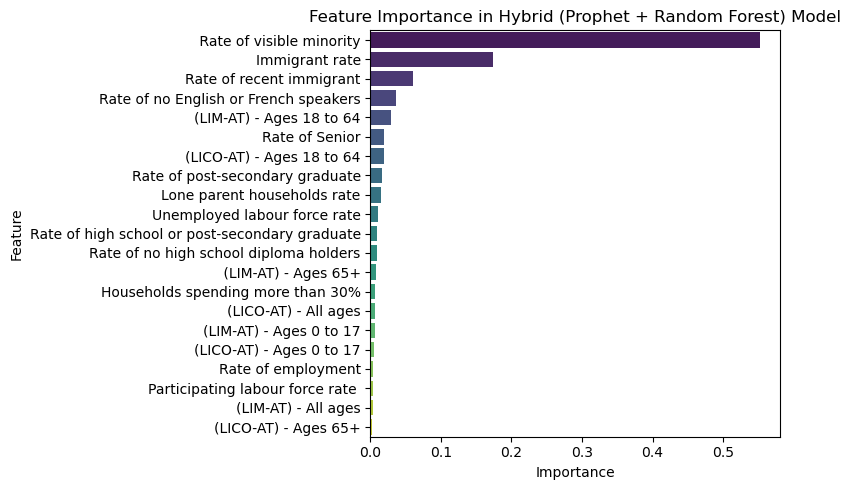

<Figure size 640x480 with 0 Axes>

In [58]:
# Get feature importances
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Feature Importance in Hybrid (Prophet + Random Forest) Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.savefig("Hybrid Prophet-Rf Importance in Mortality Prediction", dpi=300, bbox_inches="tight")

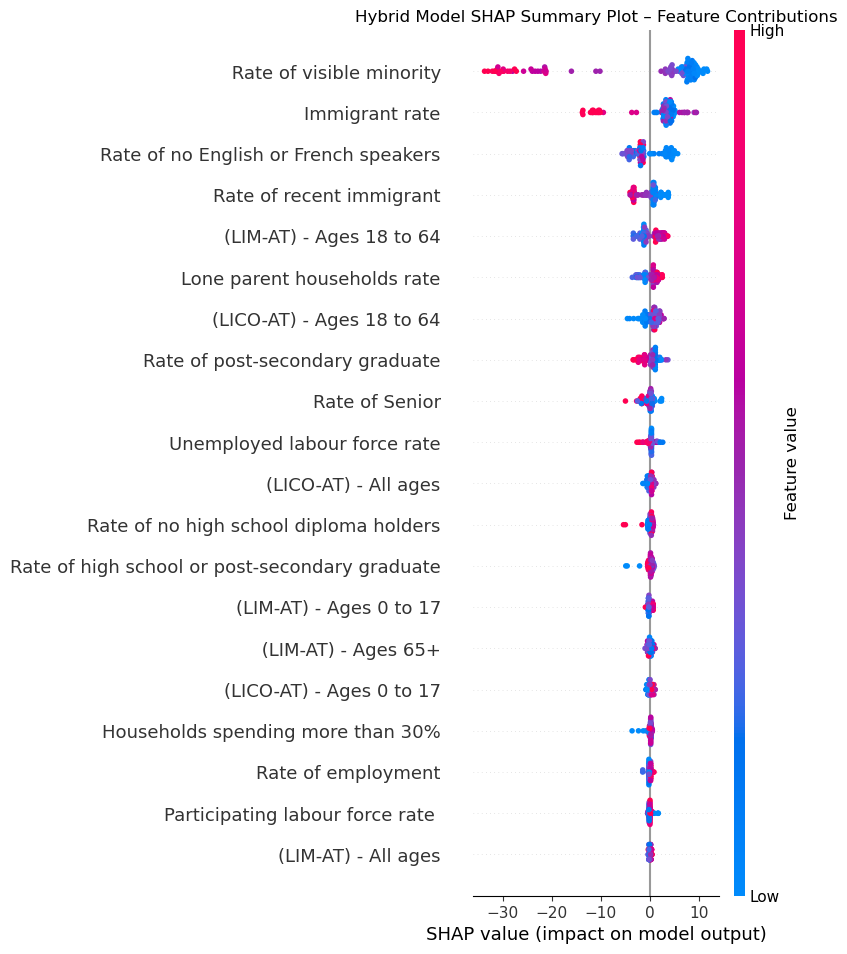

<Figure size 640x480 with 0 Axes>

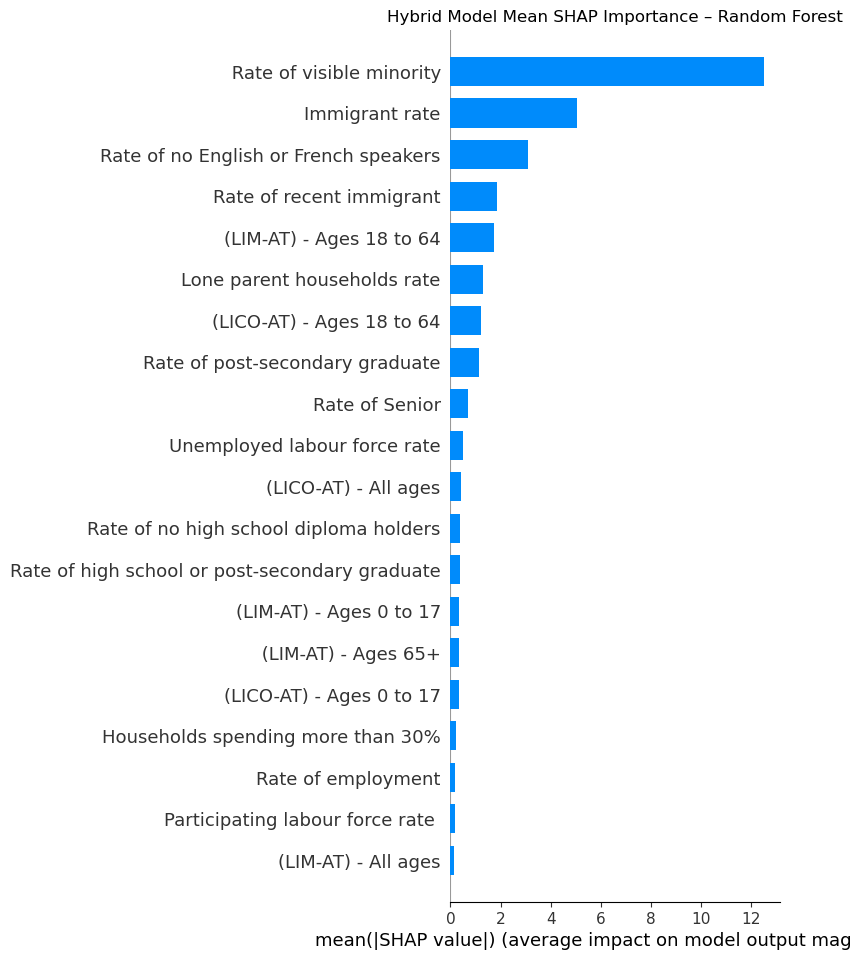

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

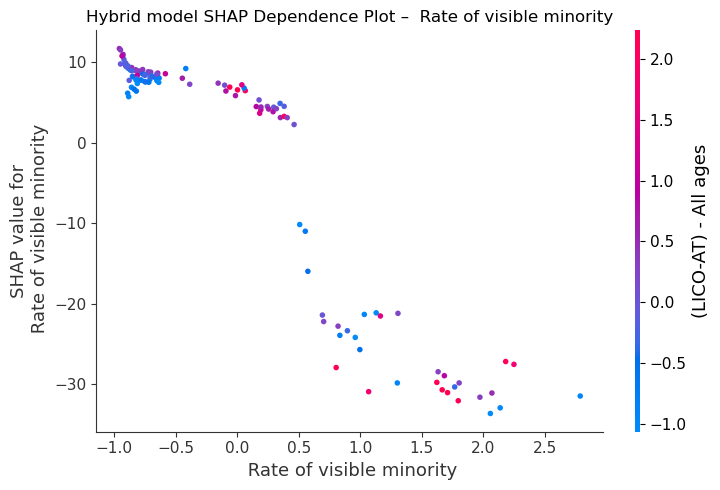

<Figure size 800x600 with 0 Axes>

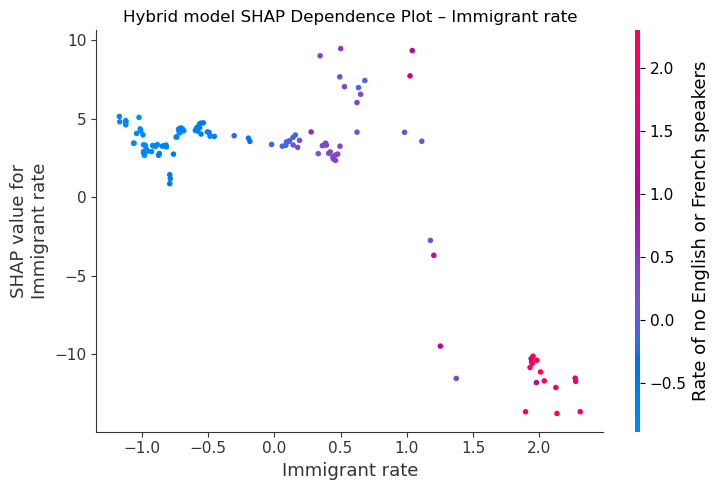

<Figure size 800x600 with 0 Axes>

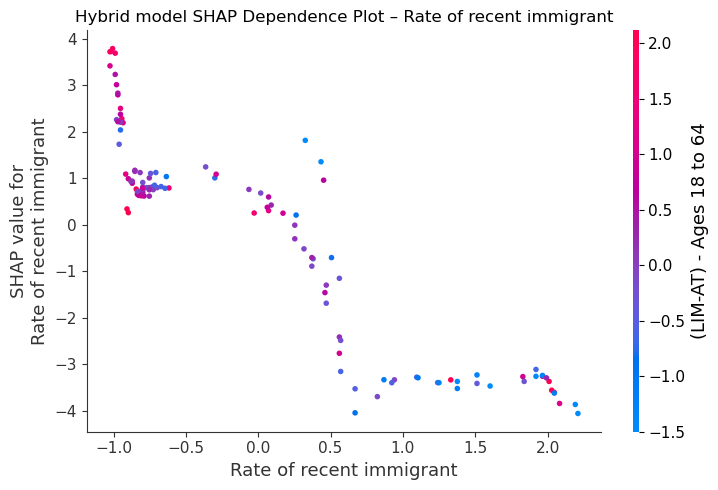

<Figure size 800x600 with 0 Axes>

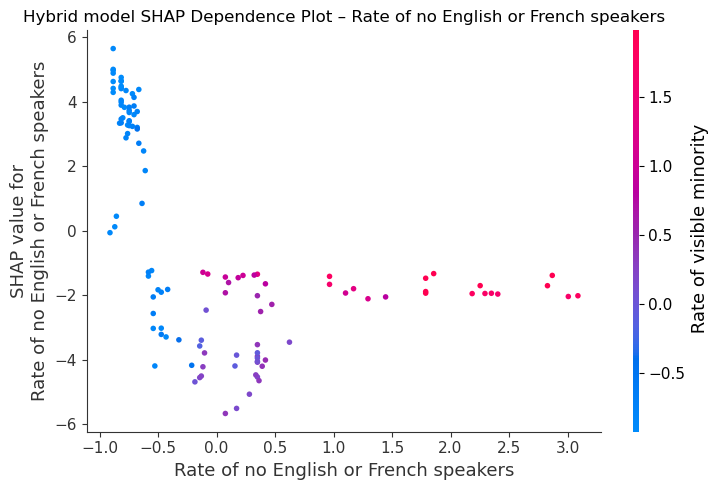

<Figure size 800x600 with 0 Axes>

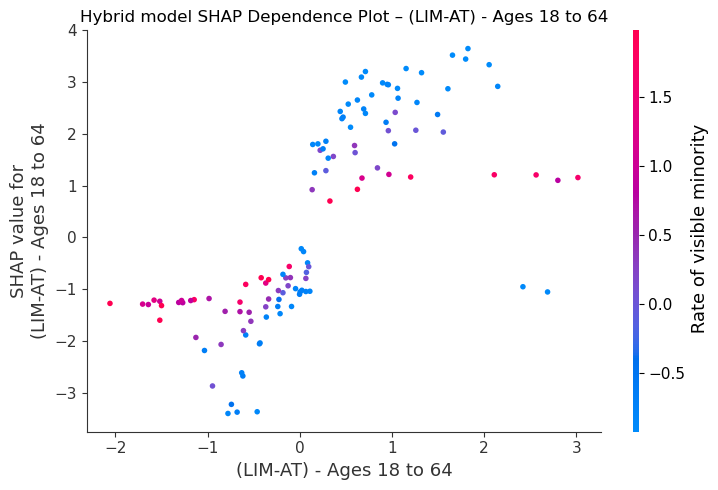

In [59]:

# SHAP EXPLAINABILITY FOR HYBRID PROPHET–RANDOM FOREST
# ======================================================

import shap

# For newer versions of SHAP that warn about numpy.bool:
shap.utils.safe_isinstance = lambda obj, types: False

# Initialize Tree SHAP explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values on the SAME data used for testing
shap_values = explainer.shap_values(X_test)

# Convert X_test back to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# ======================================================
# 1. SHAP Summary Plot (Full Feature Importance)
# ======================================================
plt.figure(figsize=(10,7))
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=False)
plt.title("Hybrid Model SHAP Summary Plot – Feature Contributions")
plt.show()
plt.savefig("Hybrid Prophet-Rf SHAP Summary Plot", dpi=300, bbox_inches="tight")
# ======================================================
# 2. SHAP Bar Plot (Mean |SHAP|)
# ======================================================
plt.figure(figsize=(10,7))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Hybrid Model Mean SHAP Importance – Random Forest")
plt.show()
plt.savefig("Hybrid Prophet-Rf Mean SHAP Importance ", dpi=300, bbox_inches="tight")

# ======================================================
# 3. SHAP Dependence Plots for the Top Features
# ======================================================
top_features = feature_importances["Feature"].head(5).tolist()

for feat in top_features:
    plt.figure(figsize=(8,6))
    shap.dependence_plot(feat, shap_values, X_test_df, show=False)
    plt.title(f"Hybrid model SHAP Dependence Plot – {feat}")
    plt.tight_layout()
    plt.show()